In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers
import tqdm

from datasets import Dataset, DatasetDict
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader

In [2]:
label_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
}

df_training = pd.read_csv("data/twitter_training.csv", names=["tweet_id", "entity", "label", "text"])
df_training = df_training[df_training.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
df_training["label"] = df_training["label"].apply(lambda l: label_mapping[str(l)])
dataset_training = Dataset.from_pandas(df_training, preserve_index=False)

df_validation = pd.read_csv("data/twitter_validation.csv", names=["tweet_id", "entity", "label", "text"])
df_validation = df_validation[df_validation.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
df_validation["label"] = df_validation["label"].apply(lambda l: label_mapping[l])
dataset_validation = Dataset.from_pandas(df_validation, preserve_index=False)

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

pad = tokenizer.pad_token_id

dataset_training = dataset_training.map(lambda s, t: {"ids": t(s["text"], truncation=True)["input_ids"] }, fn_kwargs={"t": tokenizer})
dataset_validation = dataset_validation.map(lambda s, t: {"ids": t(s["text"], truncation=True)["input_ids"] }, fn_kwargs={"t": tokenizer})

dataset_training = dataset_training.with_format(type="torch", columns=["ids", "label"])
dataset_validation = dataset_validation.with_format(type="torch", columns=["ids", "label"])

dataset_dict = DatasetDict({
    "train": dataset_training,
    "test": dataset_validation
})

dataset_dict

Map:   0%|          | 0/61121 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'ids'],
        num_rows: 61121
    })
    test: Dataset({
        features: ['label', 'text', 'ids'],
        num_rows: 828
    })
})

In [3]:
def get_dataloader(ds, batch_size, pad_index, shuffle=False):
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        
        return {
            "ids": batch_ids,
            "label": batch_label
        }
    
    dl = torch.utils.data.DataLoader(
        dataset=ds,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return dl

trdl = get_dataloader(dataset_dict["train"], 8, pad, shuffle=True)
tsdl = get_dataloader(dataset_dict["test"], 8, pad)

In [4]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes, freeze):
        super().__init__()
        
        self.transformer = transformer
        
        hidden_dim = transformer.config.hidden_size
        
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    # ids: [batch size, seq len]
    def forward(self, ids: torch.Tensor) -> torch.Tensor:
        output = self.transformer(ids, output_attentions=True)
        
        # [batch size, seq len, hidden dim]
        hidden_state = output.last_hidden_state
        
        # [batch size, n heads, seq len, seq len]
        # attention = output.attentions[-1]
        
        cls_hidden = hidden_state[:, 0, :]

        # [batch size, output dim]
        prediction = self.fc(torch.tanh(cls_hidden))
        
        return prediction

In [6]:
tf = transformers.AutoModel.from_pretrained("bert-base-uncased")

model = Transformer(tf, num_classes=3, freeze=False)

model.load_state_dict(torch.load("model/tf_model.pth", weights_only=True))

num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

print(model)

num_parameters = 109484547
Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [6]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    
    return accuracy

def train(net, dataloader, optimizer):
    net.train()
    
    epoch_losses = []
    epoch_accs = []
    
    for batch in tqdm.tqdm(dataloader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = net(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)

def test(net, dataloader):
    net.eval()
    
    epoch_losses = []
    epoch_accs = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = net(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def run_centralised(trainloader, testloader, epochs: int, lr: float):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for e in range(epochs):
        print(f"Training epoch {e} ...")
        
        train(model, trainloader, optimizer)

    loss, accuracy = test(model, testloader)
    
    print(f"{loss = }")
    print(f"{accuracy = }")

In [7]:
run_centralised(trdl, tsdl, epochs=3, lr=1e-5)

Training epoch 0 ...


training...: 100%|████████████████████████| 7641/7641 [2:42:21<00:00,  1.27s/it]


Training epoch 1 ...


training...: 100%|████████████████████████| 7641/7641 [2:43:16<00:00,  1.28s/it]


Training epoch 2 ...


evaluating...: 100%|██████████████████████████| 104/104 [00:34<00:00,  3.01it/s]

loss = 0.08496077250478826
accuracy = 0.9759615384615384


In [8]:
torch.save(model.state_dict(), "model/tf_model.pth")

In [6]:
partitioner = IidPartitioner(num_partitions=10)
partitioner.dataset = dataset_training

partitioner.load_partition(partition_id=0)

Dataset({
    features: ['label', 'text', 'ids'],
    num_rows: 6113
})

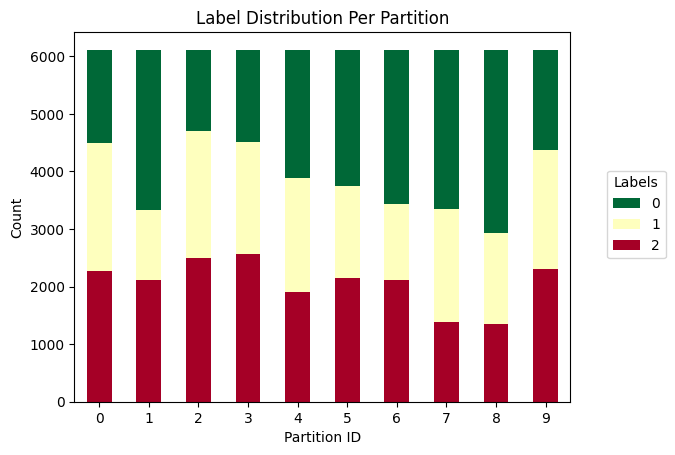

In [10]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    max_num_partitions=10,
    title="Label Distribution Per Partition",
)